# w266 Vanilla BERTbase & FinBert

### Libraries & Packages

In [ ]:
# data processessing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## NN packages
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# NLP packages
!pip install -q transformers
!pip install pydot
from transformers import BertTokenizer,TFAutoModel, TFBertModel, BertForSequenceClassification




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00


### Importing/Preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/w266/data/clean_train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/w266/data/clean_test_data.csv')

In [ ]:
# creating train/val datasets
x_train, x_val, y_train, y_val = train_test_split(train_data.text, train_data.label, test_size=0.20, random_state=42)
# creating test datasets
x_test = test_data.text
y_test = test_data.label

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (13592,)
y_train shape: (13592,)

x_val shape: (3398,)
y_val shape: (3398,)

x_test shape: (4117,)
y_test shape: (4117,)


### Gloabl Variables

In [ ]:
target_names = ["Analyst Update","Fed | Central Banks",
        "Company | Product News","Treasuries | Corporate Debt",
        "Dividend","Earnings","Energy | Oil",
        "Financials","Currencies","General News | Opinion",
        "Gold | Metals | Materials","IPO","Legal | Regulation",
        "M&A | Investments","Macro","Markets","Politics",
        "Personnel Change","Stock Commentary", "Stock Movement"]

### Utility functions

In [ ]:
# Function for creating tokenized data and outputs for models

def create_datasets(tokenizer, train=x_train, val=x_val, test=x_test):
  # Variables
  # train/val/test = datasets to encode
  # tokenizer = bert tokenizer

  train_encodings = tokenizer(list(train), padding=True, return_tensors='tf')
  valid_encodings = tokenizer(list(val), padding=True, return_tensors='tf')
  test_encodings = tokenizer(list(test), padding=True, return_tensors='tf')

  return train_encodings, valid_encodings, test_encodings


In [ ]:
 # Function for creating model
def create_bert_multiclass_model(model,
                                 num_classes = 20,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 activation='softmax'):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """

    bert_model = model

    # building bert inputs
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # building bert model
    bert_out = bert_model(bert_inputs)
    pooler_output = bert_out[1] # bert_out.pooler_output

    # building hidden layers
    last_hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='last_hidden_output')(pooler_output)
    last_hidden_output = tf.keras.layers.Dropout(dropout, name='dropout')(last_hidden_output)
    bert_cls_prediction = keras.layers.Dense(num_classes, activation=activation, name='cls_output')(last_hidden_output)

    # compiling model
    bert_cls_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=bert_cls_prediction)
    bert_cls_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics='accuracy')

    ### END YOUR CODE
    return bert_cls_model

In [ ]:
# Function to show model parameters/shape
def depict_model(model):

  display(model.summary())
  display(keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

### BERT-base model

In [ ]:
# Loading bert-base-uncased tokenizer/model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Creating BERT-base encodings
bert_train_encodings, bert_valid_encodings, bert_test_encodings = create_datasets(bert_tokenizer)

In [ ]:
# Creating BERT-base model
bert_base = create_bert_multiclass_model(bert_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                              

None

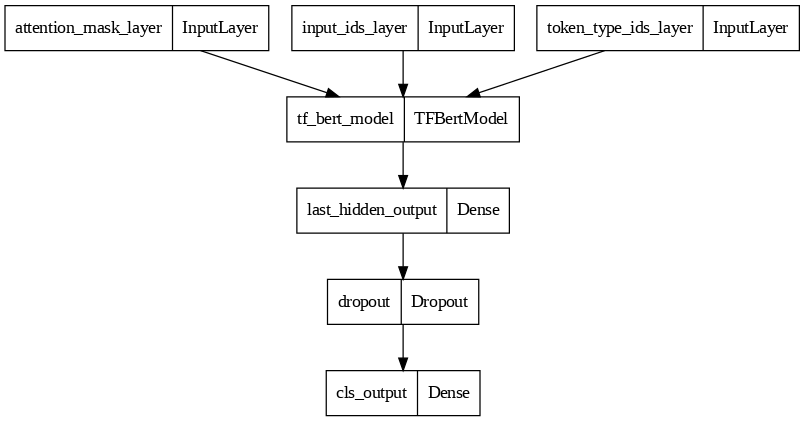

In [ ]:
# Viewing model
depict_model(bert_base)

In [ ]:
# Training bert-base model
bertbase_model_history = bert_base.fit([bert_train_encodings.input_ids, bert_train_encodings.token_type_ids, bert_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([bert_valid_encodings.input_ids, bert_valid_encodings.token_type_ids, bert_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=5)

Epoch 1/5
1699/1699 [==============================] - 151s 65ms/step - loss: 0.9669 - accuracy: 0.7312 - val_loss: 0.5023 - val_accuracy: 0.8531
Epoch 2/5
1699/1699 [==============================] - 81s 48ms/step - loss: 0.3940 - accuracy: 0.8895 - val_loss: 0.4508 - val_accuracy: 0.8805
Epoch 3/5
1699/1699 [==============================] - 79s 46ms/step - loss: 0.2519 - accuracy: 0.9338 - val_loss: 0.6023 - val_accuracy: 0.8637
Epoch 4/5
1699/1699 [==============================] - 78s 46ms/step - loss: 0.1935 - accuracy: 0.9473 - val_loss: 0.5285 - val_accuracy: 0.8793
Epoch 5/5
1699/1699 [==============================] - 77s 46ms/step - loss: 0.1587 - accuracy: 0.9582 - val_loss: 0.5021 - val_accuracy: 0.8882


In [ ]:
# Evaluating BertBase Model
bert_base_results = bert_base.evaluate([bert_test_encodings.input_ids, bert_test_encodings.token_type_ids, bert_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {bert_base_results[1]}\n"+
      f"Model loss: {bert_base_results[0]}")

515/515 [==============================] - 13s 26ms/step - loss: 0.5849 - accuracy: 0.8664
Model accuracy: 0.866407573223114
Model loss: 0.5849378108978271


In [ ]:
# Computing BERT-base F1 metric
bert_y_pred = bert_base.predict([bert_test_encodings.input_ids, bert_test_encodings.token_type_ids, bert_test_encodings.attention_mask])
pred_bert_model = tf.argmax(bert_y_pred, axis=-1)

print(classification_report(y_test, pred_bert_model.numpy(), target_names=target_names, digits=4))



                             precision    recall  f1-score   support

             Analyst Update     0.8983    0.7260    0.8030        73
        Fed | Central Banks     0.8932    0.8598    0.8762       214
     Company | Product News     0.9066    0.8768    0.8914       852
Treasuries | Corporate Debt     0.8806    0.7662    0.8194        77
                   Dividend     0.9400    0.9691    0.9543        97
                   Earnings     0.9315    0.9545    0.9429       242
               Energy | Oil     0.8800    0.7534    0.8118       146
                 Financials     0.7624    0.9625    0.8508       160
                 Currencies     0.7895    0.9375    0.8571        32
     General News | Opinion     0.8939    0.6518    0.7539       336
  Gold | Metals | Materials     0.9091    0.7692    0.8333        13
                        IPO     0.7778    1.0000    0.8750        14
         Legal | Regulation     0.8595    0.8739    0.8667       119
          M&A | Investments     0

### Finbert-pretrained Model
Basic pretrained model

In [ ]:
# Loading finbert-pretrained
finbert_base = TFAutoModel.from_pretrained('yiyanghkust/finbert-pretrain', ignore_mismatched_sizes=True, from_pt=True)
finbert_base_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
# Creating FinBert encodings
finbert_train_encodings, finbert_valid_encodings, finbert_test_encodings = create_datasets(finbert_base_tokenizer)

In [ ]:
# Creating FinBert Model
finbert_model = create_bert_multiclass_model(finbert_base)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                            

None

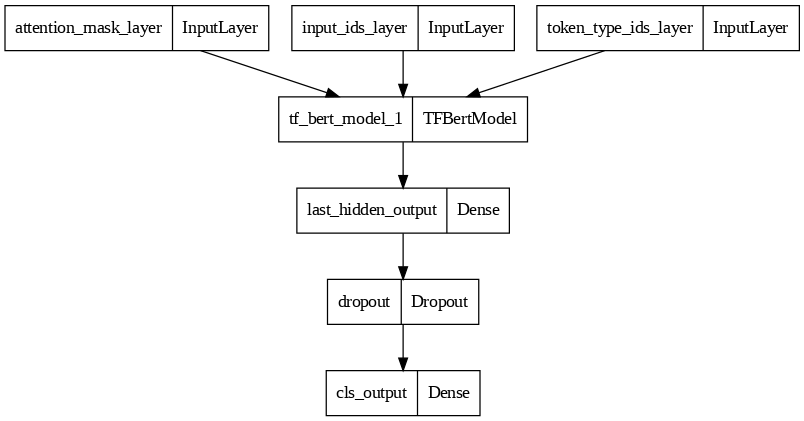

In [ ]:
# Viewing Model
depict_model(finbert_model)

In [ ]:
# Training FinBert Model
finbert_base_model_history = finbert_model.fit([finbert_train_encodings.input_ids, finbert_train_encodings.token_type_ids, finbert_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([finbert_valid_encodings.input_ids, finbert_valid_encodings.token_type_ids, finbert_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=5)

Epoch 1/5
1699/1699 [==============================] - 145s 62ms/step - loss: 0.7964 - accuracy: 0.7713 - val_loss: 0.4767 - val_accuracy: 0.8640
Epoch 2/5
1699/1699 [==============================] - 79s 47ms/step - loss: 0.3564 - accuracy: 0.8953 - val_loss: 0.4461 - val_accuracy: 0.8817
Epoch 3/5
1699/1699 [==============================] - 80s 47ms/step - loss: 0.2127 - accuracy: 0.9386 - val_loss: 0.4675 - val_accuracy: 0.8802
Epoch 4/5
1699/1699 [==============================] - 77s 45ms/step - loss: 0.1814 - accuracy: 0.9475 - val_loss: 0.6170 - val_accuracy: 0.8752
Epoch 5/5
1699/1699 [==============================] - 75s 44ms/step - loss: 0.1506 - accuracy: 0.9589 - val_loss: 0.6740 - val_accuracy: 0.8726


In [ ]:
# Evaluating FinBert Model
finbert_results = finbert_model.evaluate([finbert_test_encodings.input_ids, finbert_test_encodings.token_type_ids, finbert_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {finbert_results[1]}\n"+
      f"Model loss: {finbert_results[0]}")

515/515 [==============================] - 15s 24ms/step - loss: 0.6535 - accuracy: 0.8749
Model accuracy: 0.8749089241027832
Model loss: 0.6534751057624817


In [ ]:
# Computing FinBert F1 metric
finbert_y_pred = finbert_model.predict([finbert_test_encodings.input_ids, finbert_test_encodings.token_type_ids, finbert_test_encodings.attention_mask])
pred_finbert_model = tf.argmax(finbert_y_pred, axis=-1)

print(classification_report(y_test, pred_finbert_model.numpy(), target_names=target_names, digits=4))



                             precision    recall  f1-score   support

             Analyst Update     0.8000    0.8219    0.8108        73
        Fed | Central Banks     0.9497    0.7944    0.8651       214
     Company | Product News     0.8223    0.9448    0.8793       852
Treasuries | Corporate Debt     0.9531    0.7922    0.8652        77
                   Dividend     0.9789    0.9588    0.9688        97
                   Earnings     0.9669    0.9669    0.9669       242
               Energy | Oil     0.9323    0.8493    0.8889       146
                 Financials     0.8968    0.8688    0.8825       160
                 Currencies     0.9600    0.7500    0.8421        32
     General News | Opinion     0.7342    0.7976    0.7646       336
  Gold | Metals | Materials     0.8667    1.0000    0.9286        13
                        IPO     0.9333    1.0000    0.9655        14
         Legal | Regulation     0.8632    0.8487    0.8559       119
          M&A | Investments     0